In [1]:
# Librerias
from datetime import date, datetime
from sqlalchemy import create_engine
import re
import os
import smtplib
import time
import configparser
# Manipulacion y tratamiento de datos
import numpy as np
import pandas as pd

# Graficos
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import hvplot.pandas
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.graphics.tsaplots import plot_pacf
import plotly.express as px
import plotly.graph_objects as go

plt.style.use('fivethirtyeight')
plt.rcParams['lines.linewidth'] = 1.5
plt.rcParams["figure.figsize"] = (12, 8)
dark_style = {
    'figure.facecolor': '#212946',
    'axes.facecolor': '#212946',
    'savefig.facecolor':'#212946',
    'axes.grid': True,
    'axes.grid.which': 'both',
    'axes.spines.left': False,
    'axes.spines.right': False,
    'axes.spines.top': False,
    'axes.spines.bottom': False,
    'grid.color': '#2A3459',
    'grid.linewidth': '1',
    'text.color': '0.9',
    'axes.labelcolor': '0.9',
    'xtick.color': '0.9',
    'ytick.color': '0.9',
    'font.size': 12 }
plt.rcParams.update(dark_style)

In [2]:
# Evaluaciones de Modelos

def evaluacion_metricas(y_true, y_pred):
    def mean_absolute_percentage_error(y_true, y_pred):
        y_true, y_pred = np.array(y_true), np.array(y_pred)
        return np.mean(np.abs((y_true-y_pred)/y_true)) *100
    print('Evaluación de las metricas resultados:-')
    print(f'MSE es: {metrics.mean_squared_error(y_true, y_pred)}')
    print(f'MAE es: {metrics.mean_absolute_error(y_true, y_pred)}')
    print(f'RMSE es: {np.sqrt(metrics.mean_squared_error(y_true, y_pred))}')
    print(f'MAPE es: {mean_absolute_percentage_error(y_true, y_pred)}')
    print(f'R^2 es: {metrics.r2_score(y_true, y_pred)}', end = '\n\n')

In [3]:
# Modelacion Arima

from statsmodels.tsa.statespace.sarimax import SARIMAX
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

# Auto Arima

from pmdarima import auto_arima

# Metrica de evaluacion
from sklearn.metrics import mean_squared_error
from statsmodels.tools.eval_measures import rmse
from sklearn import metrics

In [4]:
refunds = pd.read_excel('Datos de refunds y ventas.xlsx', sheet_name='Refunds')
refunds.head()

,Fecha,Amazon,eBay,Shopify,Google,Walmart,Total
0,2020-01-01,421.27,0,0,0.0,0,421.27
1,2020-01-02,5546.81,0,0,0.0,0,5546.81
2,2020-01-03,7327.57,0,0,0.0,0,7327.57
3,2020-01-04,2726.78,0,0,0.0,0,2726.78
4,2020-01-05,1101.16,0,0,0.0,0,1101.16


In [5]:
refunds.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 7 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Fecha    1902 non-null   datetime64[ns]
 1   Amazon   1900 non-null   object        
 2   eBay     1874 non-null   object        
 3   Shopify  1877 non-null   object        
 4   Google   609 non-null    float64       
 5   Walmart  1902 non-null   object        
 6   Total    1902 non-null   float64       
dtypes: datetime64[ns](1), float64(2), object(4)
memory usage: 104.1+ KB


In [6]:
# Transformacion de la fecha datetime
refunds['Fecha'] = pd.to_datetime(refunds['Fecha'])

In [7]:
refunds.set_index('Fecha', inplace=True)
refunds.index.freq = 'D'
refunds.head()

,Amazon,eBay,Shopify,Google,Walmart,Total
Fecha,,,,,,
2020-01-01,421.27,0,0,0.0,0,421.27
2020-01-02,5546.81,0,0,0.0,0,5546.81
2020-01-03,7327.57,0,0,0.0,0,7327.57
2020-01-04,2726.78,0,0,0.0,0,2726.78
2020-01-05,1101.16,0,0,0.0,0,1101.16


In [8]:
fig = px.line(refunds, x=refunds.index, y='Total', template='plotly_dark', title='Refunds a lo largo del tiempo')
fig.show()

count     1902.000000
mean      8211.410149
std       5458.330712
min          0.000000
25%       4065.895000
50%       7474.690000
75%      11085.575000
max      38500.890000
Name: Total, dtype: float64

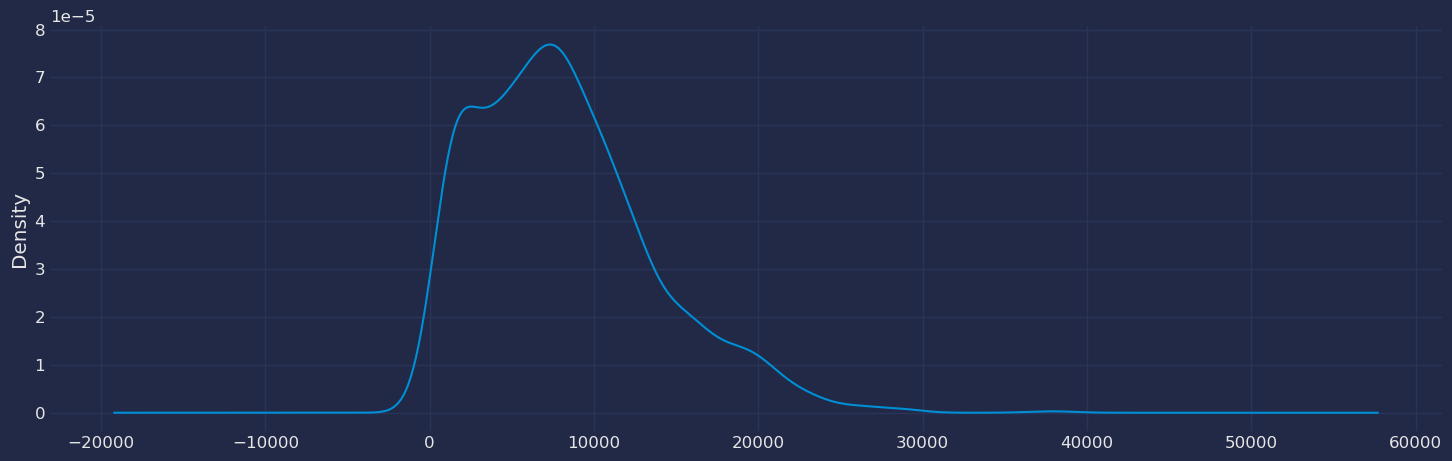

In [9]:
refunds['Total'].plot(kind= 'kde', figsize = (16,5))
refunds['Total'].describe()

In [10]:
datos = refunds.copy()

Text(0.5, 0.98, '')

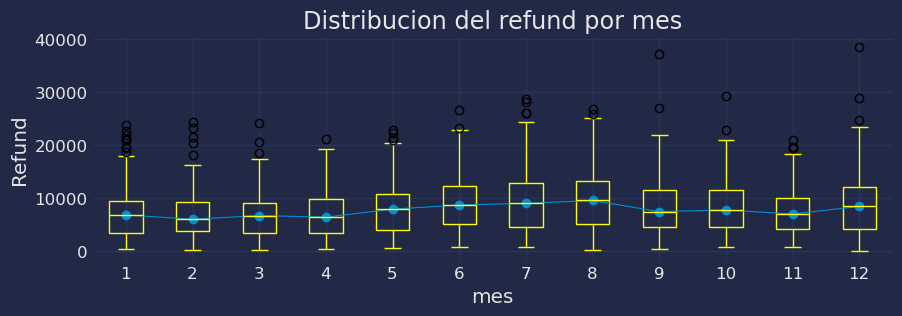

In [11]:
fig, ax = plt.subplots(figsize=(10, 3))
datos['mes'] = datos.index.month
datos.boxplot(column='Total', by='mes', ax=ax, color='yellow')
datos.groupby('mes')['Total'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Refund')
ax.set_title('Distribucion del refund por mes')
fig.suptitle('')

Text(0.5, 0.98, '')

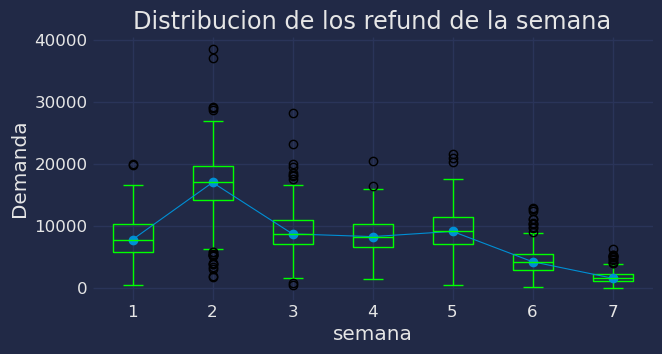

In [12]:
fig, ax = plt.subplots(figsize=(7, 3.5))
datos['semana'] = datos.index.day_of_week + 1
datos.boxplot(column='Total', by='semana', ax=ax, color='lime')
datos.groupby('semana')['Total'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Demanda')
ax.set_title('Distribucion de los refund de la semana')
fig.suptitle('')

In [13]:
#Prueba de Dickey-Fuller Aumentada
from statsmodels.tsa.stattools import adfuller
from numpy import log

def Augmented_Dickey_Fuller_Test_func(series , column_name):
    print (f'Resultados de la prueba de Dickey-Fuller para columna: {column_name}')
    dftest = adfuller(series, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic','p-value','No Lags Used','Número de observaciones utilizadas'])
    for key,value in dftest[4].items():
       dfoutput['Critical Value (%s)'%key] = value
    print (dfoutput)
    if dftest[1] <= 0.05:
        print("Conclusion:====>")
        print("Rechazar la hipótesis nula")
        print("Los datos son estacionarios")
    else:
        print("Conclusion:====>")
        print("No se puede rechazar la hipótesis nula")
        print("Los datos no son estacionarios")

In [14]:
Augmented_Dickey_Fuller_Test_func(refunds['Total'], 'Total')

Resultados de la prueba de Dickey-Fuller para columna: Total
Test Statistic                          -4.274271
p-value                                  0.000492
No Lags Used                            21.000000
Número de observaciones utilizadas    1880.000000
Critical Value (1%)                     -3.433833
Critical Value (5%)                     -2.863079
Critical Value (10%)                    -2.567589
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


In [15]:
#Transformacion de los datos a datos a estacionarios

df_1 = refunds.copy()

df_1['Total_diff'] = refunds['Total'].diff()

# removiendo los datos nulos

df_1.dropna(inplace = True)

df_1.head()

,Amazon,eBay,Shopify,Google,Walmart,Total,Total_diff
Fecha,,,,,,,
2020-01-02,5546.81,0,0,0.0,0,5546.81,5125.54
2020-01-03,7327.57,0,0,0.0,0,7327.57,1780.76
2020-01-04,2726.78,0,0,0.0,0,2726.78,-4600.79
2020-01-05,1101.16,0,0,0.0,0,1101.16,-1625.62
2020-01-06,6580.24,0,0,0.0,0,6580.24,5479.08


In [16]:
Augmented_Dickey_Fuller_Test_func(df_1['Total_diff'], 'Total_diff')

Resultados de la prueba de Dickey-Fuller para columna: Total_diff
Test Statistic                         -1.237924
p-value                                 0.657073
No Lags Used                           15.000000
Número de observaciones utilizadas    590.000000
Critical Value (1%)                    -3.441482
Critical Value (5%)                    -2.866451
Critical Value (10%)                   -2.569386
dtype: float64
Conclusion:====>
No se puede rechazar la hipótesis nula
Los datos no son estacionarios


In [17]:
fig = px.line(df_1, x=df_1.index, y='Total', template='plotly_dark', title='Refunds a lo largo del tiempo')
fig.show()

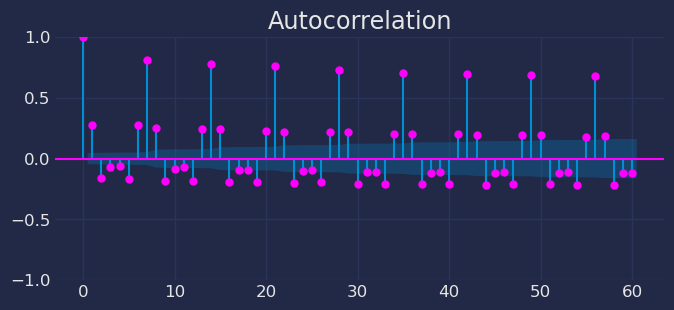

In [18]:
# Grafica de Autocorelacion

fig, ax = plt.subplots(figsize = (7,3))
plot_acf(refunds['Total'], ax = ax, lags = 60, color = 'fuchsia')
plt.show()

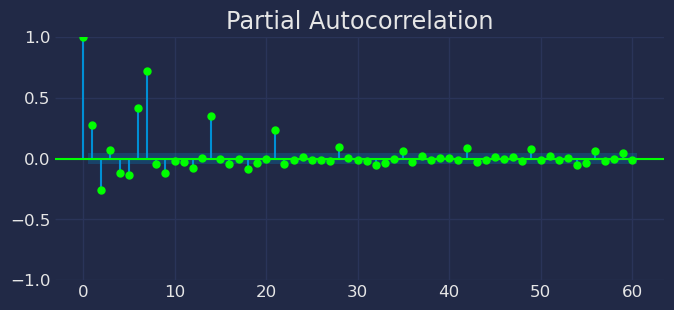

In [19]:
fig, ax = plt.subplots(figsize = (7,3))
plot_pacf(refunds['Total'], ax = ax, lags = 60, color = 'lime')
plt.show()

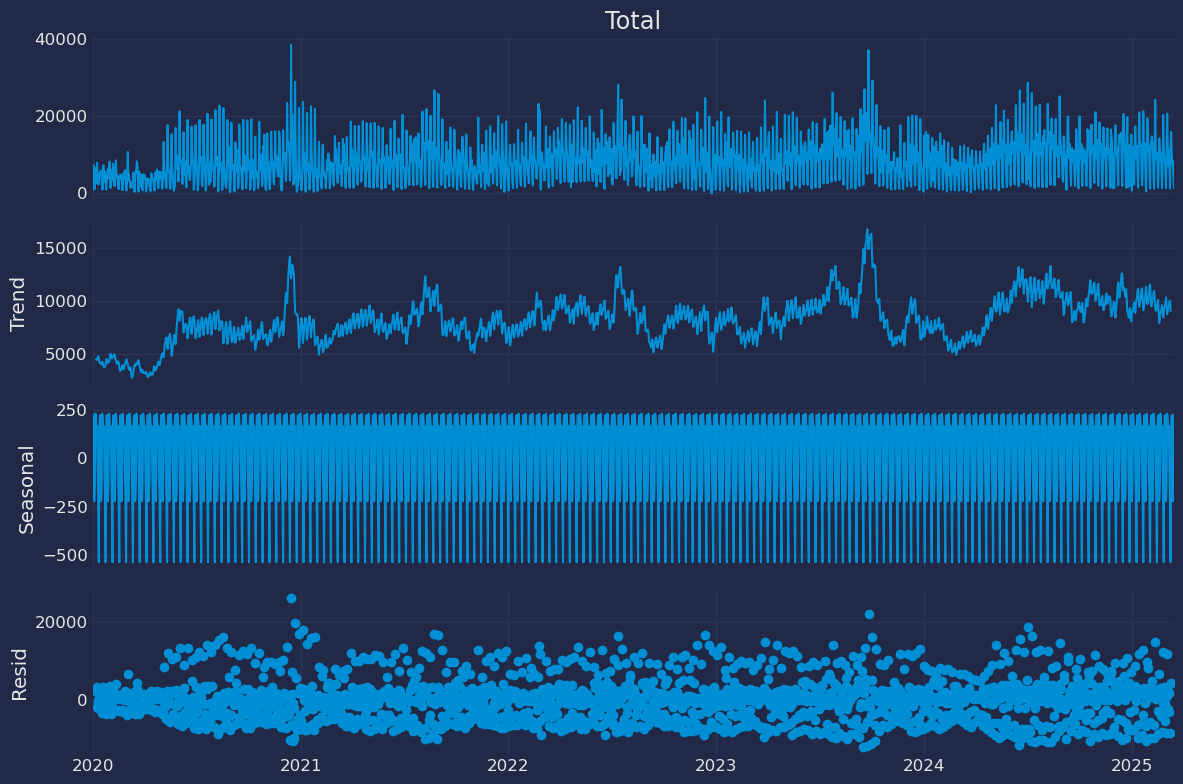

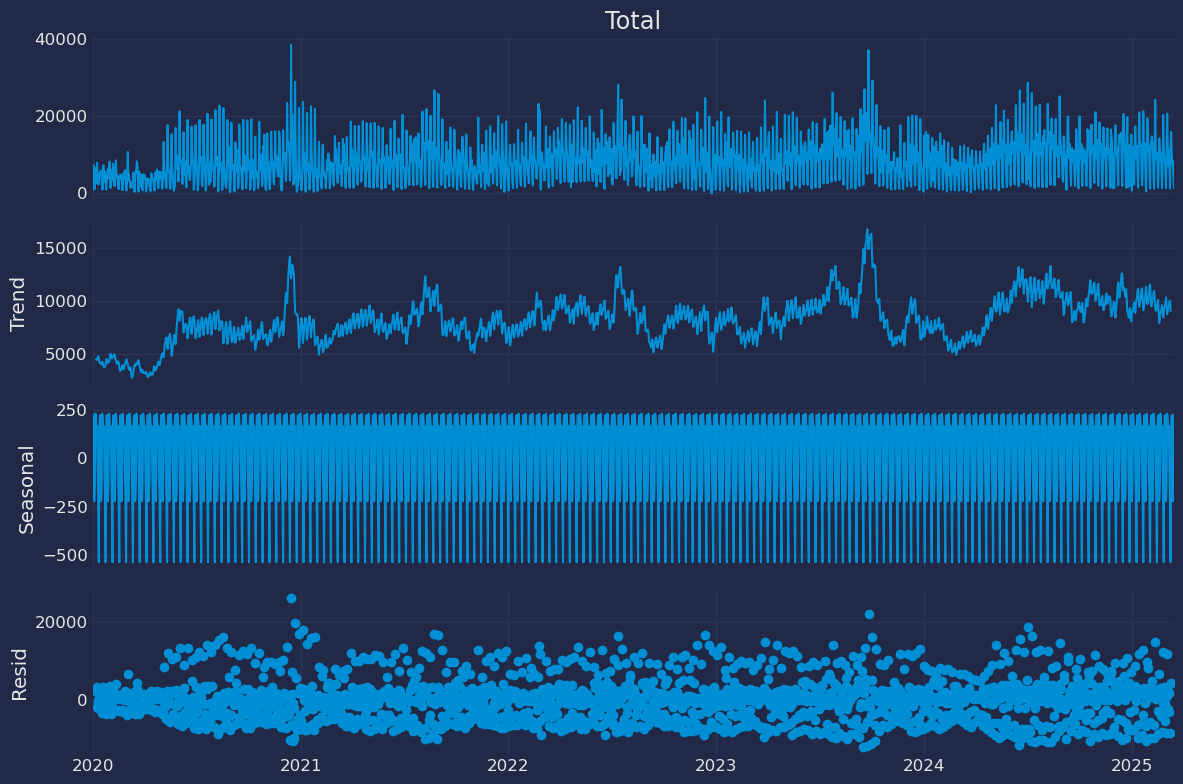

In [20]:
plt.rcParams['figure.figsize'] = (12,8)
a = seasonal_decompose(refunds['Total'], model='add',period = 12)
a.plot()

<Axes: xlabel='Fecha'>

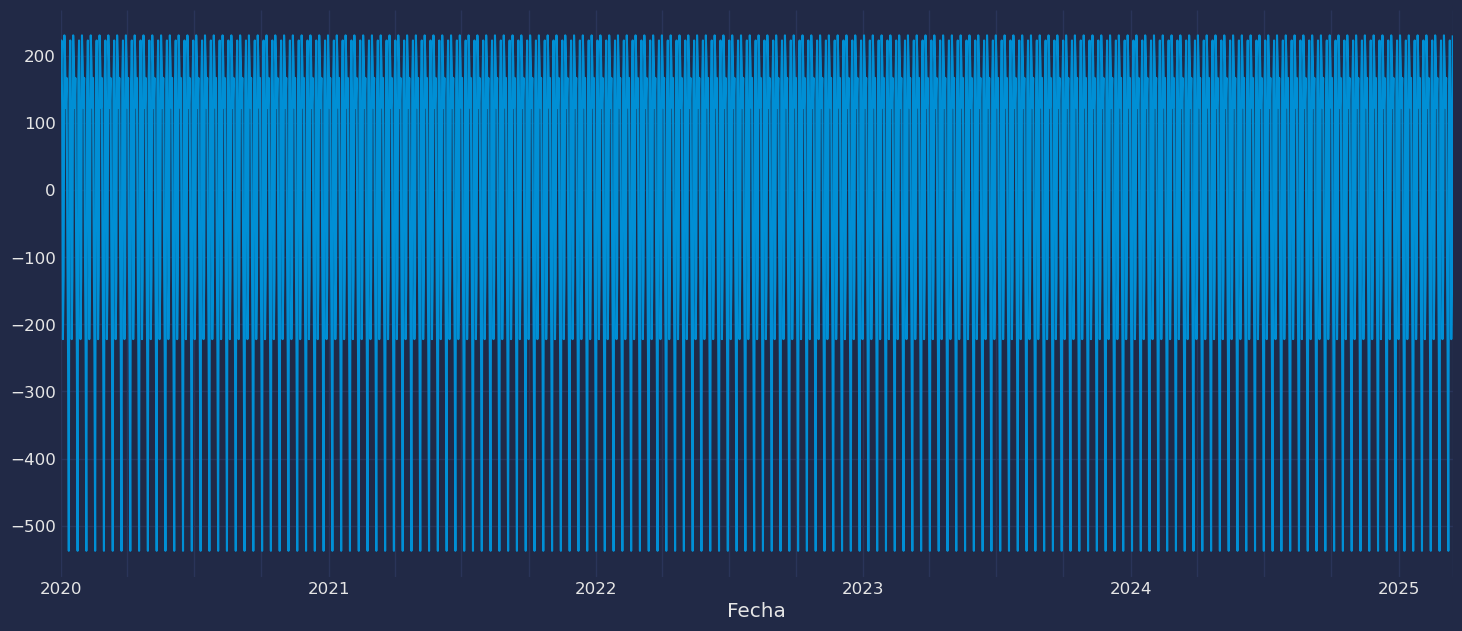

In [21]:
plt.figure(figsize=(16,7))
a.seasonal.plot()

In [22]:
#Division de los datos de entrenamiento y prueba

train_data = refunds[:len(refunds) -32]
test_data = refunds[len(refunds)-32:]
test = test_data.copy()
train_data.shape, test_data.shape

((1870, 6), (32, 6))

In [23]:
train_data.head()

,Amazon,eBay,Shopify,Google,Walmart,Total
Fecha,,,,,,
2020-01-01,421.27,0,0,0.0,0,421.27
2020-01-02,5546.81,0,0,0.0,0,5546.81
2020-01-03,7327.57,0,0,0.0,0,7327.57
2020-01-04,2726.78,0,0,0.0,0,2726.78
2020-01-05,1101.16,0,0,0.0,0,1101.16


In [24]:
train_data.drop(['Amazon', 'eBay', 'Shopify','Walmart', 'Google'], axis=1, inplace=True)
train_data.head()

C:\Users\javij\AppData\Local\Temp\ipykernel_10312\1319972633.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Total
Fecha,
2020-01-01,421.27
2020-01-02,5546.81
2020-01-03,7327.57
2020-01-04,2726.78
2020-01-05,1101.16


In [25]:
test_data.head()

,Amazon,eBay,Shopify,Google,Walmart,Total
Fecha,,,,,,
2025-02-13,7077.25,118.04,1845.98,NaN,0,9041.27
2025-02-14,8649.93,276.62,1620.84,NaN,0,10547.39
2025-02-15,6787.1,54.64,352.87,NaN,0,7194.61
2025-02-16,1418.29,-,71.44,NaN,0,1489.73
2025-02-17,5469.38,44.74,236.99,NaN,0,5751.11


In [26]:
test_data.drop(['Amazon', 'eBay', 'Shopify','Walmart', 'Google'], axis=1, inplace=True)
test_data.head()

C:\Users\javij\AppData\Local\Temp\ipykernel_10312\3308773436.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Total
Fecha,
2025-02-13,9041.27
2025-02-14,10547.39
2025-02-15,7194.61
2025-02-16,1489.73
2025-02-17,5751.11


In [27]:
# Modelo de Auto_Arima

modelo_auto_arima = auto_arima(train_data, start_P=0, d=1, start_q=0,
                                max_p=4, max_d=2, max_q=4,
                                D=1, start_Q=0, max_P=2, max_D=1,
                                max_Q=2, m=7, seasonal=True, error_action='warn', trace=True,
                                supress_warnings=True, stepwise=True, random_state=20, n_fits=50)
print(modelo_auto_arima)

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,1,0)[7]             : AIC=35963.123, Time=0.17 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=36658.375, Time=0.05 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=35725.352, Time=0.25 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=34848.364, Time=1.59 sec
 ARIMA(0,1,1)(0,1,0)[7]             : AIC=inf, Time=0.30 sec
 ARIMA(0,1,1)(1,1,1)[7]             : AIC=34823.262, Time=2.39 sec
 ARIMA(0,1,1)(1,1,0)[7]             : AIC=inf, Time=0.73 sec
 ARIMA(0,1,1)(2,1,1)[7]             : AIC=inf, Time=4.40 sec
 ARIMA(0,1,1)(1,1,2)[7]             : AIC=inf, Time=5.01 sec
 ARIMA(0,1,1)(0,1,2)[7]             : AIC=34828.424, Time=2.19 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=35023.253, Time=1.73 sec
 ARIMA(0,1,1)(2,1,2)[7]             : AIC=inf, Time=5.21 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=35810.897, Time=0.35 sec
 ARIMA(1,1,1)(1,1,1)[7]             : AIC=34814.005, Time=2.45 sec
 ARIMA(1,1,1)(0,1,1)[7]             : AIC=34841.7

In [28]:
print(modelo_auto_arima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1870
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -17402.002
Date:                           Mon, 17 Mar 2025   AIC                          34814.005
Time:                                   11:15:55   BIC                          34841.652
Sample:                               01-01-2020   HQIC                         34824.193
                                    - 02-12-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0911      0.020      4.525      0.000       0.052       0.130
ma.L1         -0.9221      0.009    -99.819

In [29]:
predicciones = modelo_auto_arima.predict(start=len(train_data), end=len(refunds['Total']) - 1, typ='levels')

### Implementacion de Sarimax

In [30]:
arima_model = SARIMAX(train_data['Total'], order =(0,1,1), seasonal_order=(2,1,1,7)).fit()

c:\Users\javij\anaconda3\lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning:

Maximum Likelihood optimization failed to converge. Check mle_retvals



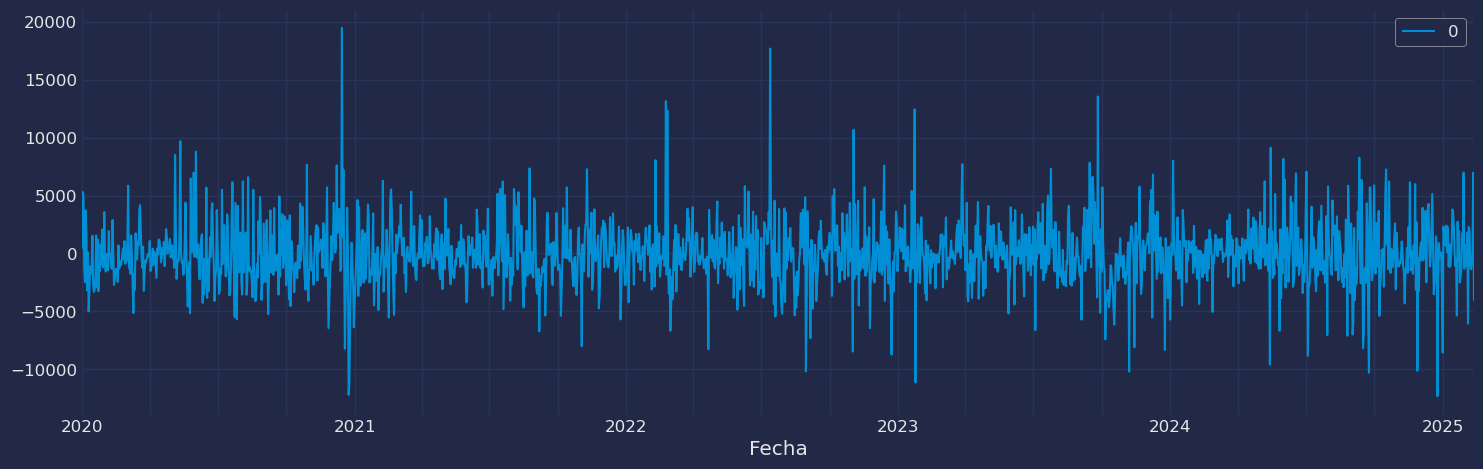

In [31]:
residuals = pd.DataFrame(arima_model.resid)
residuals.plot(figsize = (16,5));
plt.show();

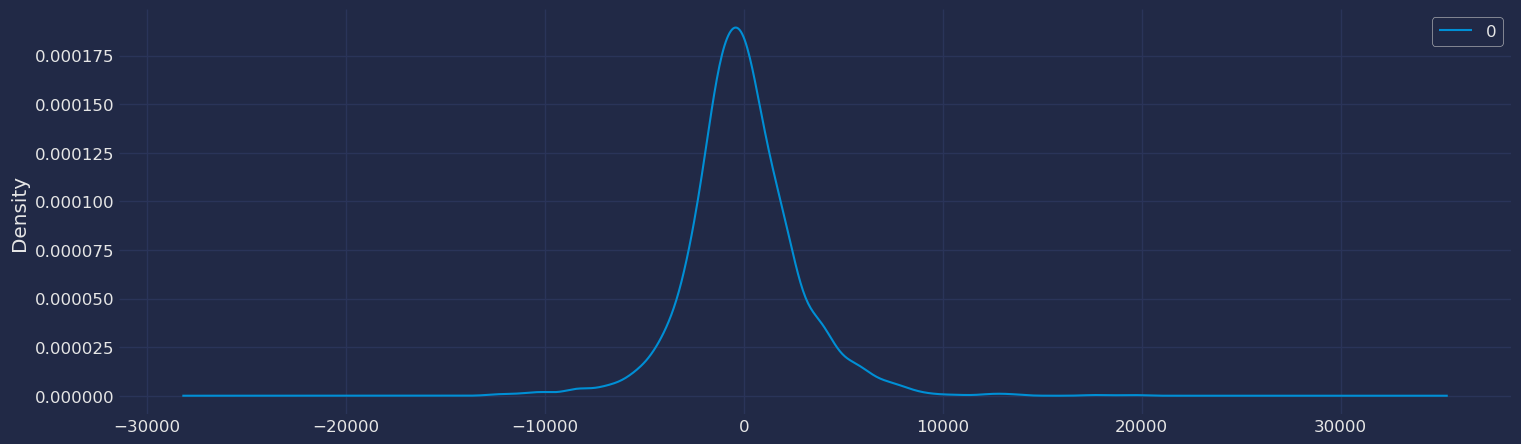

                  0
count   1870.000000
mean     -34.235597
std     2774.758236
min   -12327.986144
25%    -1473.785060
50%     -181.103719
75%     1330.404859
max    19482.623281


In [32]:
residuals.plot(kind = 'kde', figsize = (16,5))
plt.show()
print(residuals.describe())

### Intepretacion 

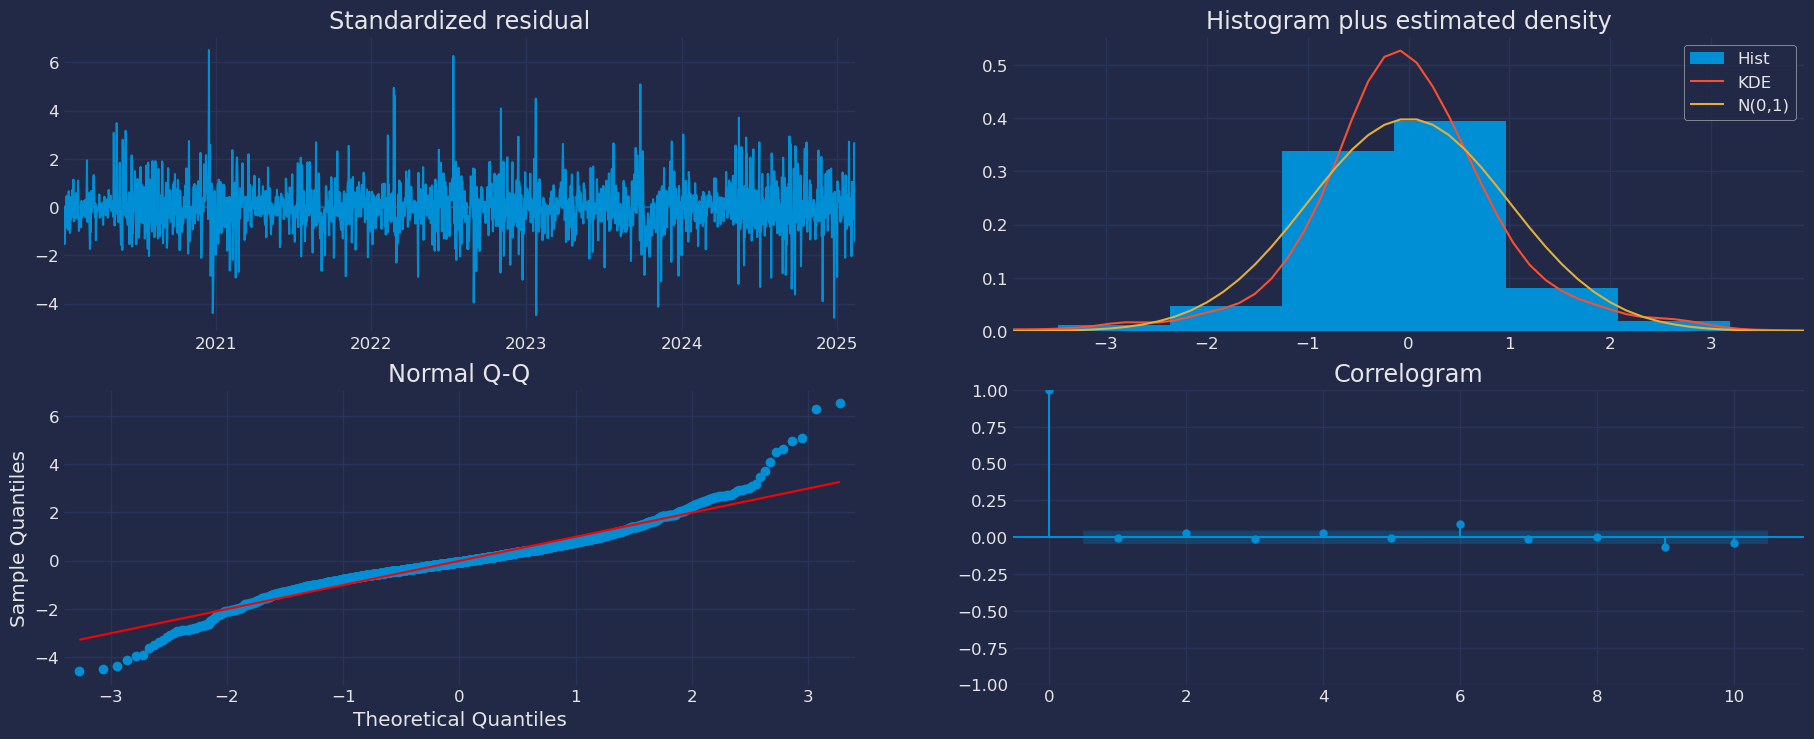

In [33]:
modelo_auto_arima.plot_diagnostics(figsize=(20,8))
plt.show()

In [34]:
len(train_data)

1870

In [35]:
len(refunds['Total'])-1

1901

In [36]:
arima_pred = arima_model.predict(start=len(train_data), end = len(refunds['Total'])-1, typ = 'levels')
arima_pred = arima_pred.abs()
arima_pred

c:\Users\javij\anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



2025-02-13    11616.322902
2025-02-14    11906.105175
2025-02-15     5857.266831
2025-02-16     2286.157867
2025-02-17    10958.533261
2025-02-18    19273.623253
2025-02-19    11472.885509
2025-02-20    11611.870735
2025-02-21    11932.495301
2025-02-22     6069.808832
2025-02-23     2530.632573
2025-02-24    10858.748687
2025-02-25    19618.965875
2025-02-26    11248.929178
2025-02-27    11427.045039
2025-02-28    12064.034486
2025-03-01     6310.289630
2025-03-02     2743.439851
2025-03-03    10868.420232
2025-03-04    19065.194752
2025-03-05    11488.018431
2025-03-06    11401.928778
2025-03-07    12111.508205
2025-03-08     6405.387661
2025-03-09     2836.652399
2025-03-10    10873.197833
2025-03-11    19005.152428
2025-03-12    11526.545878
2025-03-13    11388.198893
2025-03-14    12154.304279
2025-03-15     6472.556240
2025-03-16     2899.844669
Freq: D, Name: predicted_mean, dtype: float64

In [37]:
arima_pred2 = arima_model.predict(start = '2025-03-17', end='2025-04-05', typ = 'levels')
arima_pred2 = arima_pred2.abs()
arima_pred2

2025-03-17    10891.023955
2025-03-18    18936.287108
2025-03-19    11581.265884
2025-03-20    11397.526580
2025-03-21    12185.249014
2025-03-22     6514.926180
2025-03-23     2941.109159
2025-03-24    10911.049202
2025-03-25    18929.154564
2025-03-26    11613.643457
2025-03-27    11413.322870
2025-03-28    12213.020405
2025-03-29     6548.317349
2025-03-30     2973.747991
2025-03-31    10933.233479
2025-04-01    18934.273432
2025-04-02    11643.262714
2025-04-03    11433.494430
2025-04-04    12238.575802
2025-04-05     6576.564397
Freq: D, Name: predicted_mean, dtype: float64

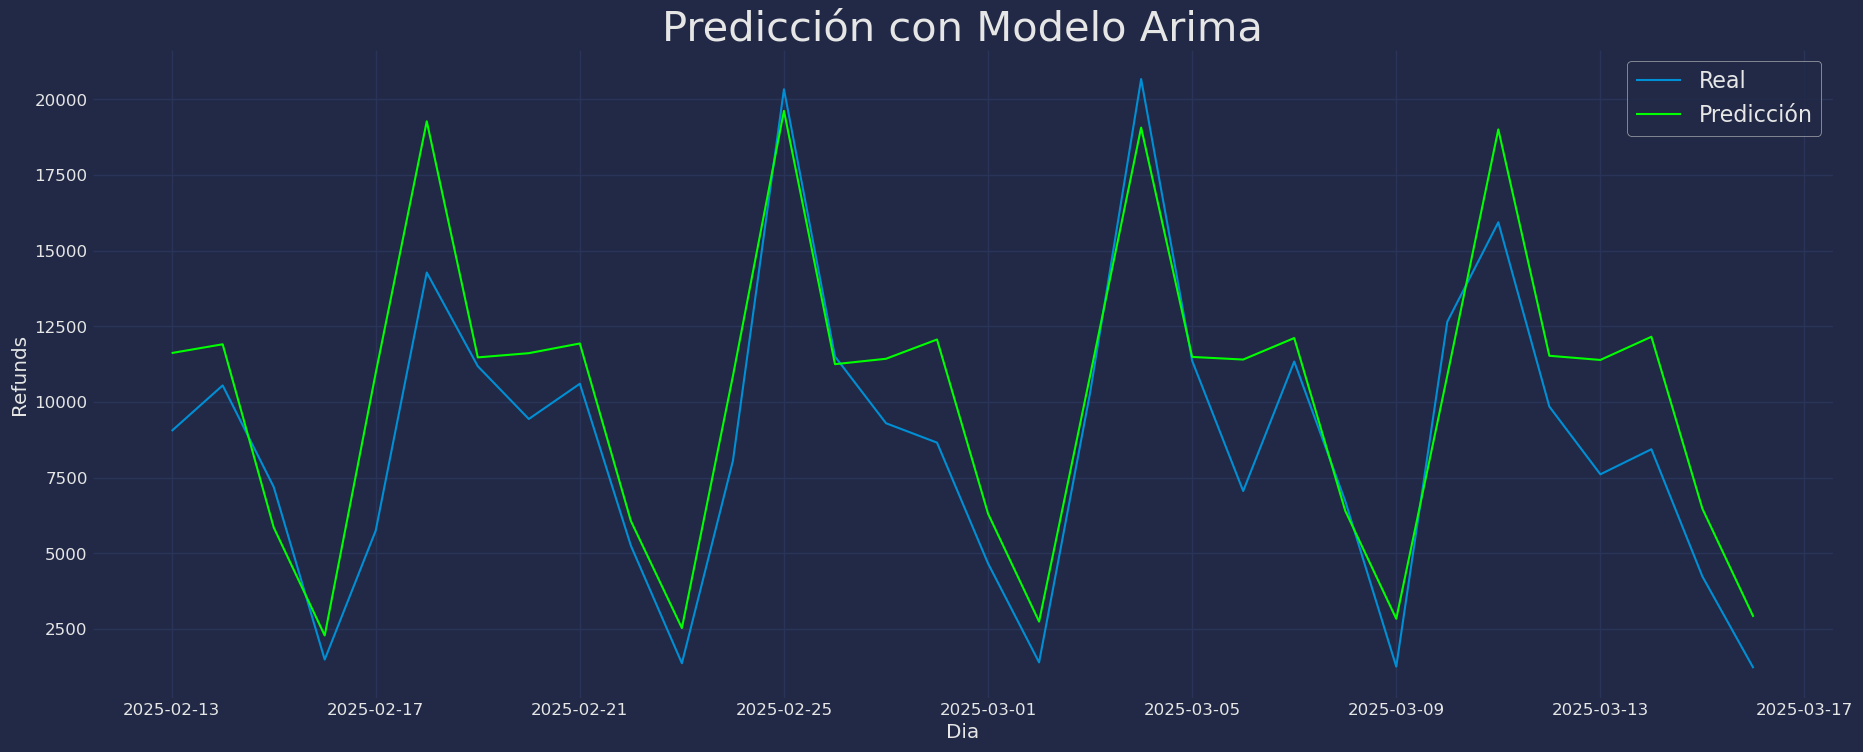

In [38]:
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(test_data['Total'],label='Real')
plt.plot(arima_pred,color='lime', label = 'Predicción')
plt.title('Predicción con Modelo Arima', fontsize = 30)
plt.xlabel('Dia')
plt.ylabel('Refunds')
plt.legend(fontsize = 16)
plt.show()

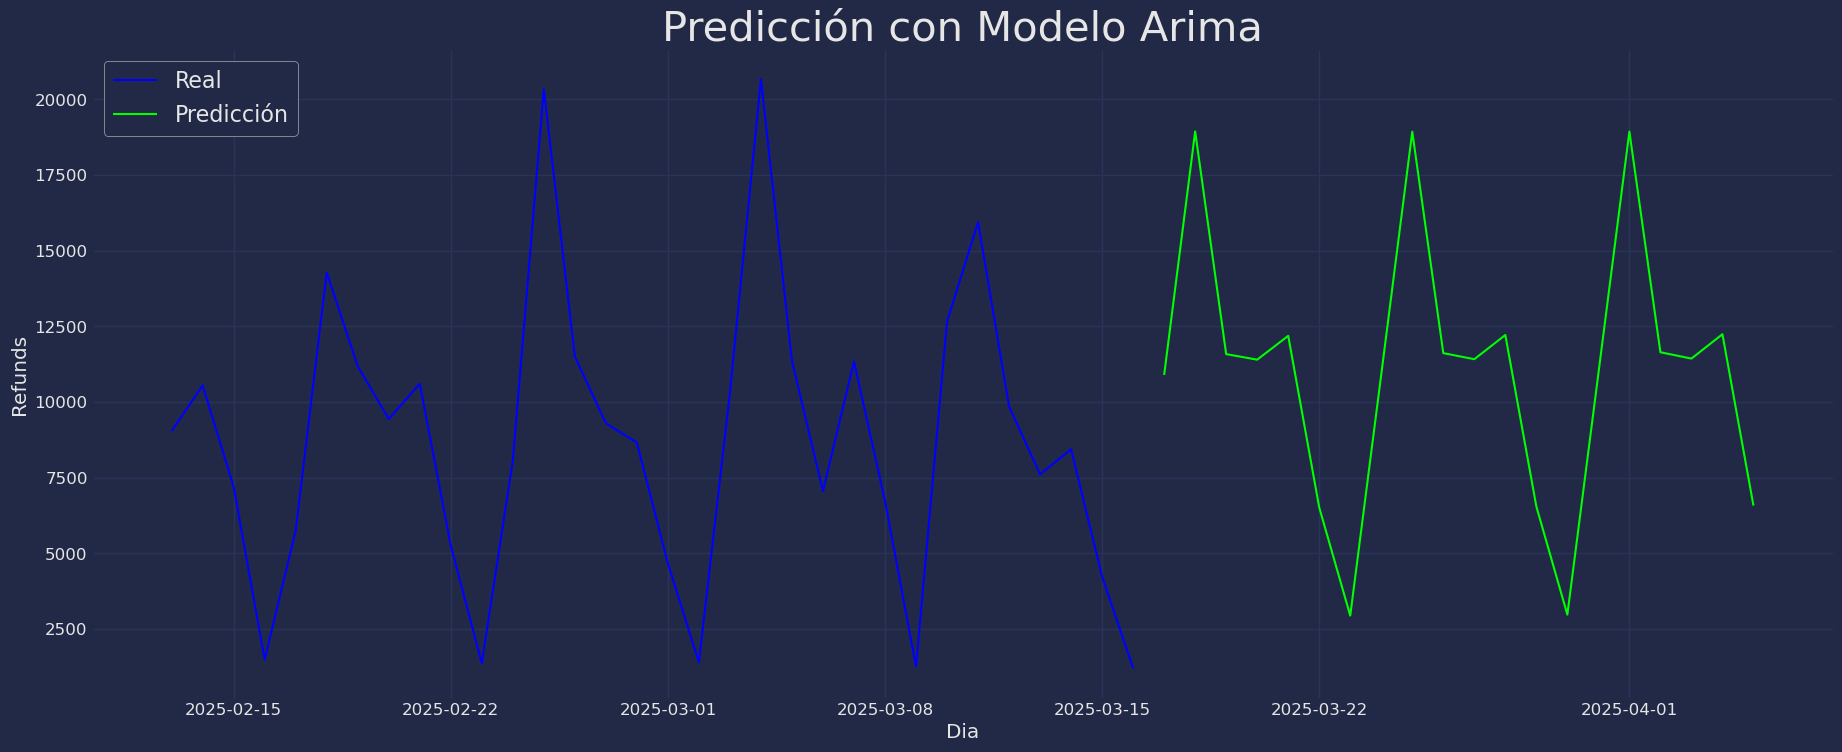

In [39]:
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(test_data['Total'],label='Real', color ='blue')
plt.plot(arima_pred2,color='lime', label = 'Predicción')
plt.title('Predicción con Modelo Arima', fontsize = 30)
plt.xlabel('Dia')
plt.ylabel('Refunds')
plt.legend(fontsize = 16)
plt.show()

In [40]:
evaluacion_metricas(test_data['Total'],arima_pred)

Evaluación de las metricas resultados:-
MSE es: 5531740.338193461
MAE es: 1925.4297313969678
RMSE es: 2351.965207691955
MAPE es: 36.342462145622235
R^2 es: 0.765727391524325



In [41]:
test_data['Arima_Predictions'] = arima_pred
test_data

C:\Users\javij\AppData\Local\Temp\ipykernel_10312\2811964639.py:1: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



,Total,Arima_Predictions
Fecha,,
2025-02-13,9041.27,11616.322902
2025-02-14,10547.39,11906.105175
2025-02-15,7194.61,5857.266831
2025-02-16,1489.73,2286.157867
2025-02-17,5751.11,10958.533261
2025-02-18,14277.11,19273.623253
2025-02-19,11181.71,11472.885509
2025-02-20,9437.69,11611.870735
2025-02-21,10602.01,11932.495301


In [42]:
arima_pred2

2025-03-17    10891.023955
2025-03-18    18936.287108
2025-03-19    11581.265884
2025-03-20    11397.526580
2025-03-21    12185.249014
2025-03-22     6514.926180
2025-03-23     2941.109159
2025-03-24    10911.049202
2025-03-25    18929.154564
2025-03-26    11613.643457
2025-03-27    11413.322870
2025-03-28    12213.020405
2025-03-29     6548.317349
2025-03-30     2973.747991
2025-03-31    10933.233479
2025-04-01    18934.273432
2025-04-02    11643.262714
2025-04-03    11433.494430
2025-04-04    12238.575802
2025-04-05     6576.564397
Freq: D, Name: predicted_mean, dtype: float64

### Ventas

In [43]:
ventas = pd.read_excel('Datos de refunds y ventas.xlsx', sheet_name='Ventas')
ventas.head()

,Fecha,Total
0,2020-01-01,114838.8201
1,2020-01-02,132846.9601
2,2020-01-03,130644.7101
3,2020-01-04,120840.9203
4,2020-01-05,129750.7500


In [44]:
ventas.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1902 entries, 0 to 1901
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype         
---  ------  --------------  -----         
 0   Fecha   1902 non-null   datetime64[ns]
 1   Total   1902 non-null   float64       
dtypes: datetime64[ns](1), float64(1)
memory usage: 29.8 KB


In [45]:
# Transformacion de la fecha datetime
ventas['Fecha'] = pd.to_datetime(ventas['Fecha'])

In [46]:
ventas.set_index('Fecha', inplace=True)
ventas.index.freq = 'D'
ventas.head()

,Total
Fecha,
2020-01-01,114838.8201
2020-01-02,132846.9601
2020-01-03,130644.7101
2020-01-04,120840.9203
2020-01-05,129750.7500


In [47]:
fig = px.line(ventas, x=ventas.index, y='Total', template='plotly_dark', title='Ventas a lo largo del tiempo')
fig.show()

count      1902.000000
mean     184091.058175
std       48269.892242
min        1259.930000
25%      152523.744725
50%      181047.030000
75%      212270.042525
max      475509.590000
Name: Total, dtype: float64

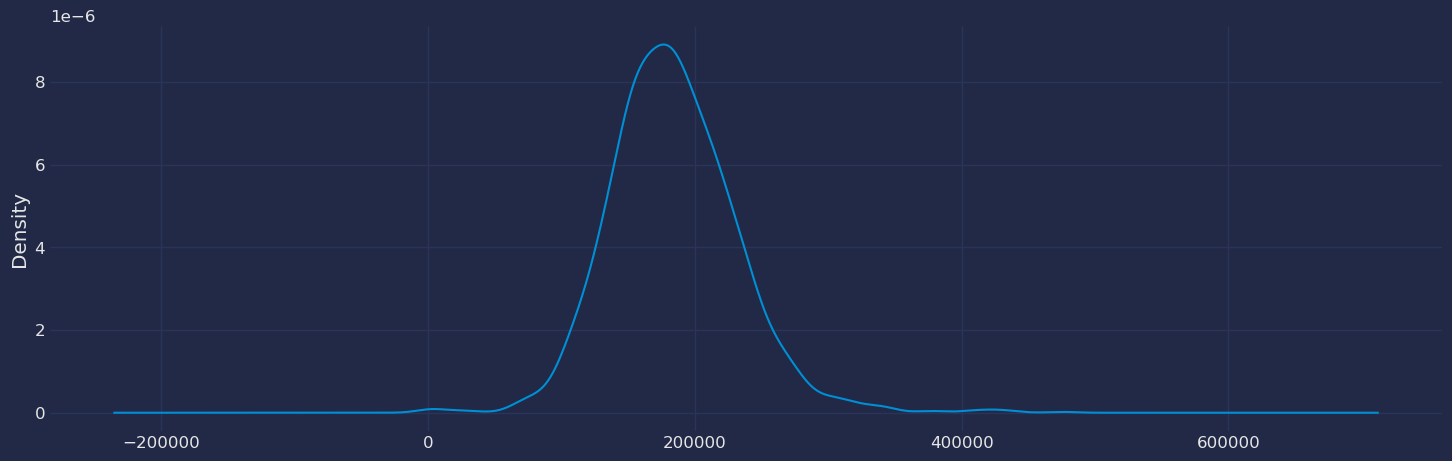

In [48]:
ventas['Total'].plot(kind= 'kde', figsize = (16,5))
ventas['Total'].describe()

In [49]:
datos2 = ventas.copy()

Text(0.5, 0.98, '')

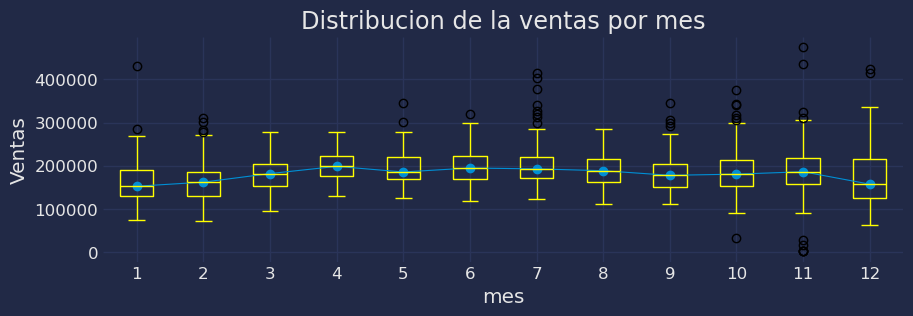

In [50]:
fig, ax = plt.subplots(figsize=(10, 3))
datos2['mes'] = datos2.index.month
datos2.boxplot(column='Total', by='mes', ax=ax, color='yellow')
datos2.groupby('mes')['Total'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Ventas')
ax.set_title('Distribucion de la ventas por mes')
fig.suptitle('')

Text(0.5, 0.98, '')

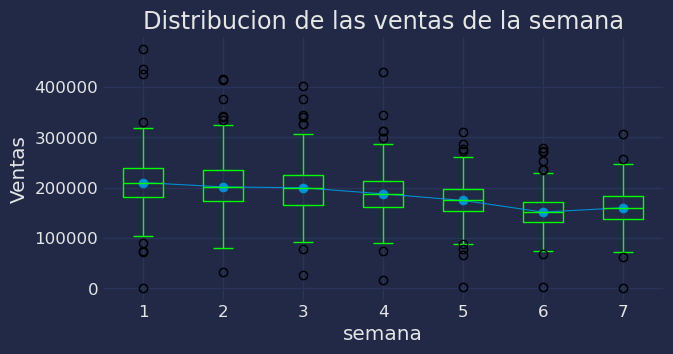

In [51]:
fig, ax = plt.subplots(figsize=(7, 3.5))
datos2['semana'] = datos2.index.day_of_week + 1
datos2.boxplot(column='Total', by='semana', ax=ax, color='lime')
datos2.groupby('semana')['Total'].median().plot(style='o-', linewidth=0.8, ax=ax)
ax.set_ylabel('Ventas')
ax.set_title('Distribucion de las ventas de la semana')
fig.suptitle('')

In [52]:
Augmented_Dickey_Fuller_Test_func(ventas['Total'], 'Total')

Resultados de la prueba de Dickey-Fuller para columna: Total
Test Statistic                          -5.190756
p-value                                  0.000009
No Lags Used                            26.000000
Número de observaciones utilizadas    1875.000000
Critical Value (1%)                     -3.433842
Critical Value (5%)                     -2.863083
Critical Value (10%)                    -2.567591
dtype: float64
Conclusion:====>
Rechazar la hipótesis nula
Los datos son estacionarios


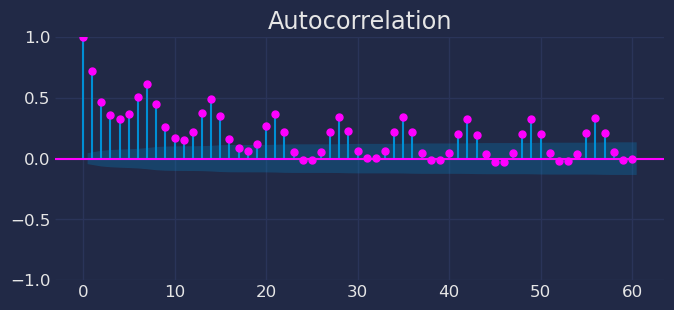

In [53]:
# Grafica de Autocorelacion

fig, ax = plt.subplots(figsize = (7,3))
plot_acf(ventas['Total'], ax = ax, lags = 60, color = 'fuchsia')
plt.show()

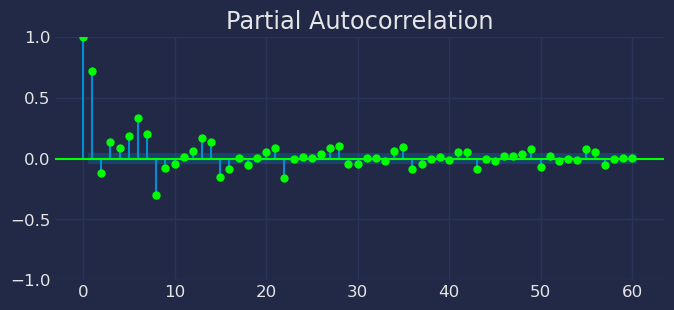

In [54]:
fig, ax = plt.subplots(figsize = (7,3))
plot_pacf(ventas['Total'], ax = ax, lags = 60, color = 'lime')
plt.show()

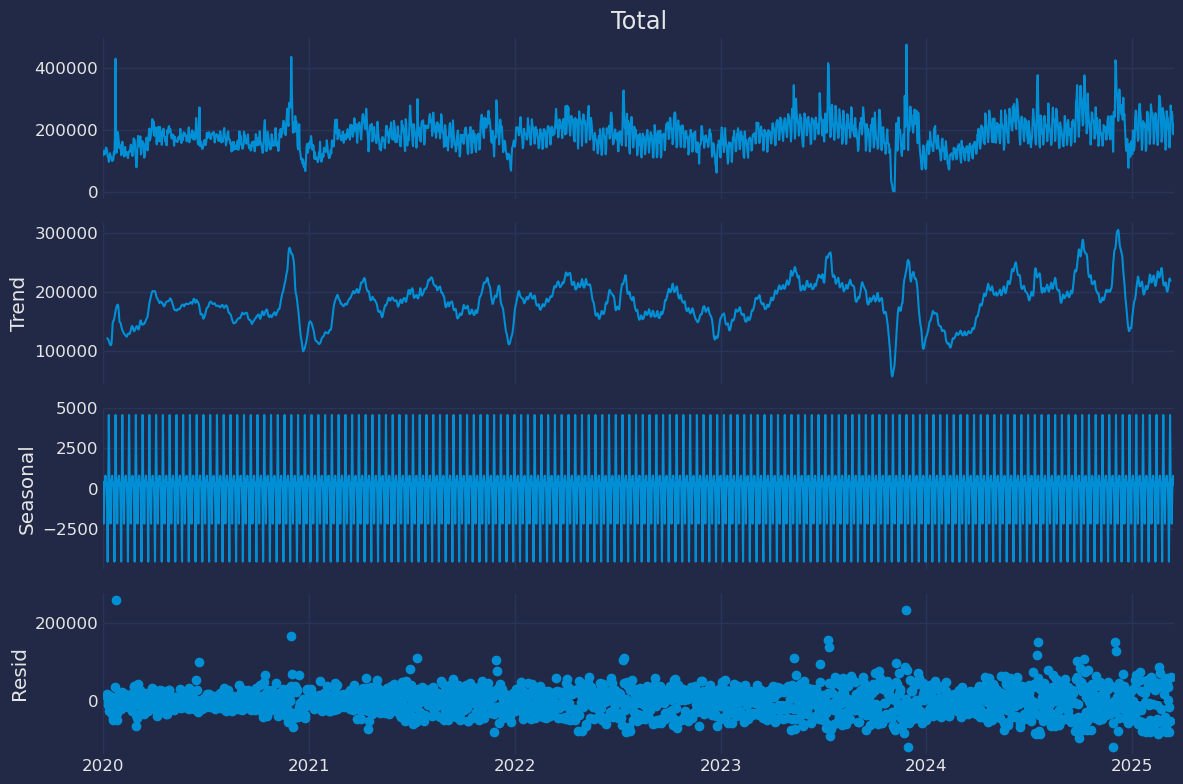

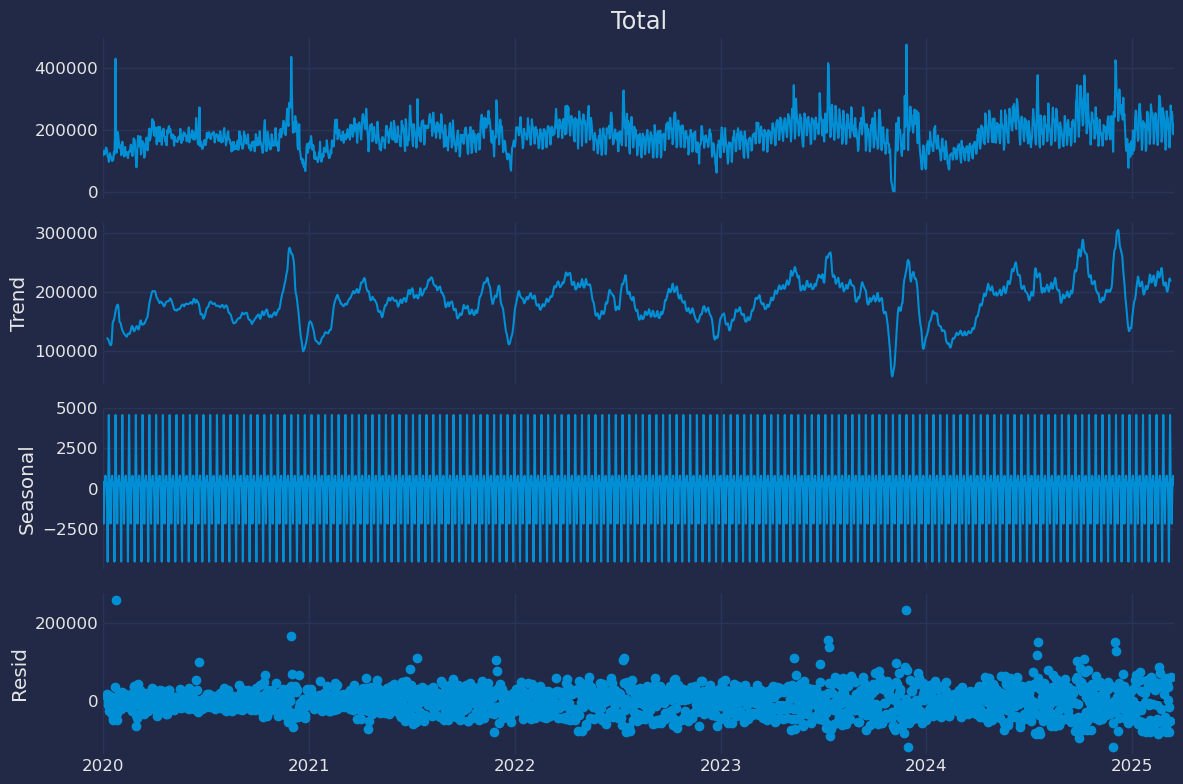

In [55]:
plt.rcParams['figure.figsize'] = (12,8)
a = seasonal_decompose(ventas['Total'], model='add',period = 12)
a.plot()

<Axes: xlabel='Fecha'>

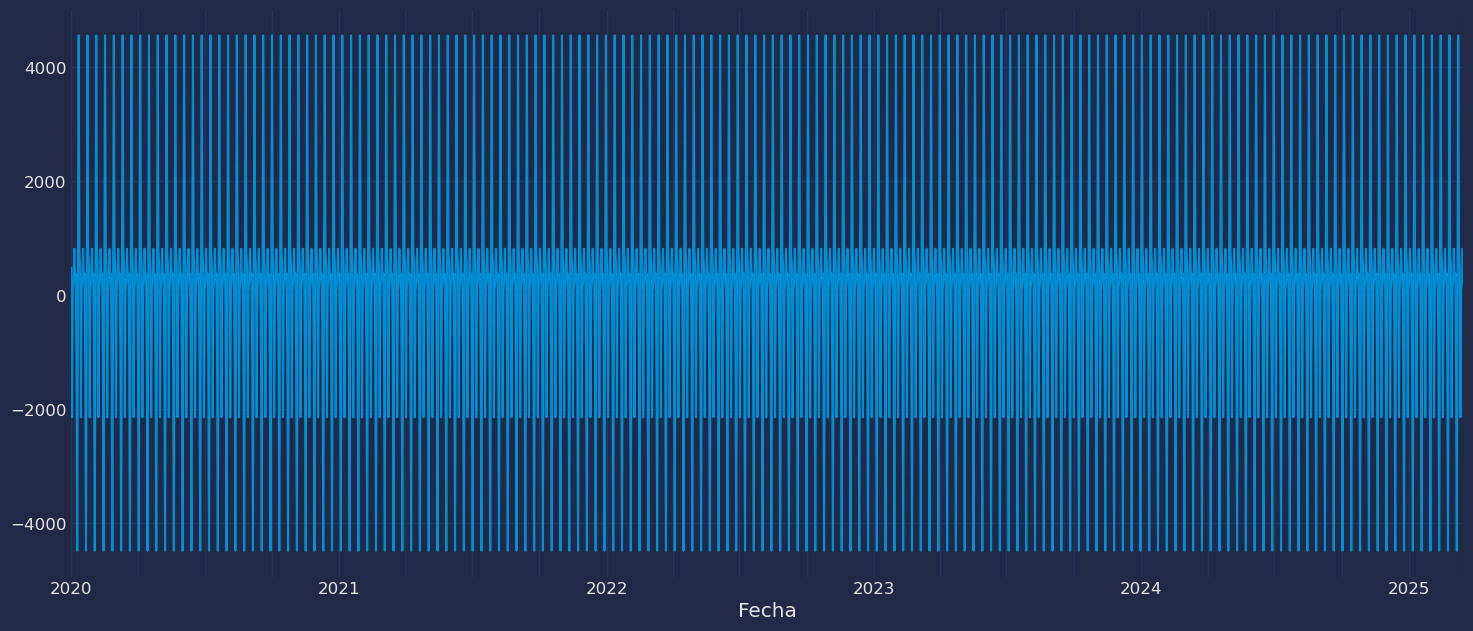

In [56]:
plt.figure(figsize=(16,7))
a.seasonal.plot()

In [57]:
#Division de los datos de entrenamiento y prueba

train_data2 = ventas[:len(ventas) -32]
test_data2 = ventas[len(ventas)-32:]
test2 = test_data2.copy()
train_data2.shape, test_data2.shape

((1870, 1), (32, 1))

In [58]:
train_data2.head()

,Total
Fecha,
2020-01-01,114838.8201
2020-01-02,132846.9601
2020-01-03,130644.7101
2020-01-04,120840.9203
2020-01-05,129750.7500


In [59]:
test_data2.head()

,Total
Fecha,
2025-02-13,213816.5098
2025-02-14,180507.6600
2025-02-15,150857.0205
2025-02-16,176482.2900
2025-02-17,265286.8599


In [60]:
# Modelo de Auto_Arima

modelo_auto_arima_ventas = auto_arima(train_data2, start_P=0, d=1, start_q=0,
                                max_p=4, max_d=2, max_q=4,
                                D=1, start_Q=0, max_P=2, max_D=1,
                                max_Q=2, m=7, seasonal=True, error_action='warn', trace=True,
                                supress_warnings=True, stepwise=True, random_state=20, n_fits=50)
print(modelo_auto_arima)

Performing stepwise search to minimize aic
 ARIMA(2,1,0)(0,1,0)[7]             : AIC=44267.362, Time=0.18 sec
 ARIMA(0,1,0)(0,1,0)[7]             : AIC=44403.701, Time=0.04 sec
 ARIMA(1,1,0)(1,1,0)[7]             : AIC=43917.741, Time=0.27 sec
 ARIMA(0,1,1)(0,1,1)[7]             : AIC=inf, Time=1.53 sec
 ARIMA(1,1,0)(0,1,0)[7]             : AIC=44343.764, Time=0.12 sec
 ARIMA(1,1,0)(2,1,0)[7]             : AIC=43762.976, Time=0.44 sec
 ARIMA(1,1,0)(2,1,1)[7]             : AIC=inf, Time=1.34 sec
 ARIMA(1,1,0)(1,1,1)[7]             : AIC=inf, Time=0.59 sec
 ARIMA(0,1,0)(2,1,0)[7]             : AIC=43715.601, Time=0.32 sec
 ARIMA(0,1,0)(1,1,0)[7]             : AIC=43939.033, Time=0.14 sec
 ARIMA(0,1,0)(2,1,1)[7]             : AIC=inf, Time=0.98 sec
 ARIMA(0,1,0)(1,1,1)[7]             : AIC=inf, Time=0.44 sec
 ARIMA(0,1,1)(2,1,0)[7]             : AIC=43720.365, Time=0.52 sec
 ARIMA(1,1,1)(2,1,0)[7]             : AIC=inf, Time=2.30 sec
 ARIMA(0,1,0)(2,1,0)[7] intercept   : AIC=43831.868, Ti

In [61]:
print(modelo_auto_arima.summary())

                                     SARIMAX Results                                     
Dep. Variable:                                 y   No. Observations:                 1870
Model:             SARIMAX(1, 1, 1)x(1, 1, 1, 7)   Log Likelihood              -17402.002
Date:                           Mon, 17 Mar 2025   AIC                          34814.005
Time:                                   11:16:14   BIC                          34841.652
Sample:                               01-01-2020   HQIC                         34824.193
                                    - 02-12-2025                                         
Covariance Type:                             opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0911      0.020      4.525      0.000       0.052       0.130
ma.L1         -0.9221      0.009    -99.819

In [62]:
predicciones_ventas = modelo_auto_arima.predict(start=len(train_data2), end=len(ventas['Total']) - 1, typ='levels')

In [63]:
arima_model_ventas = SARIMAX(train_data2['Total'], order =(0,1,1), seasonal_order=(2,1,1,7)).fit()

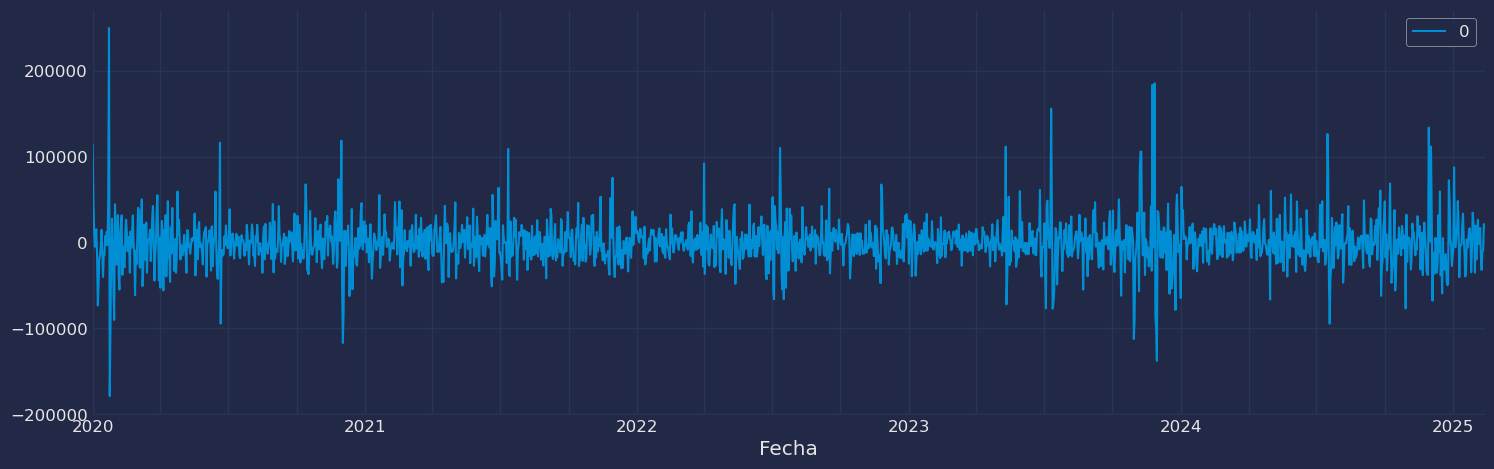

In [64]:
residuals = pd.DataFrame(arima_model_ventas.resid)
residuals.plot(figsize = (16,5));
plt.show();

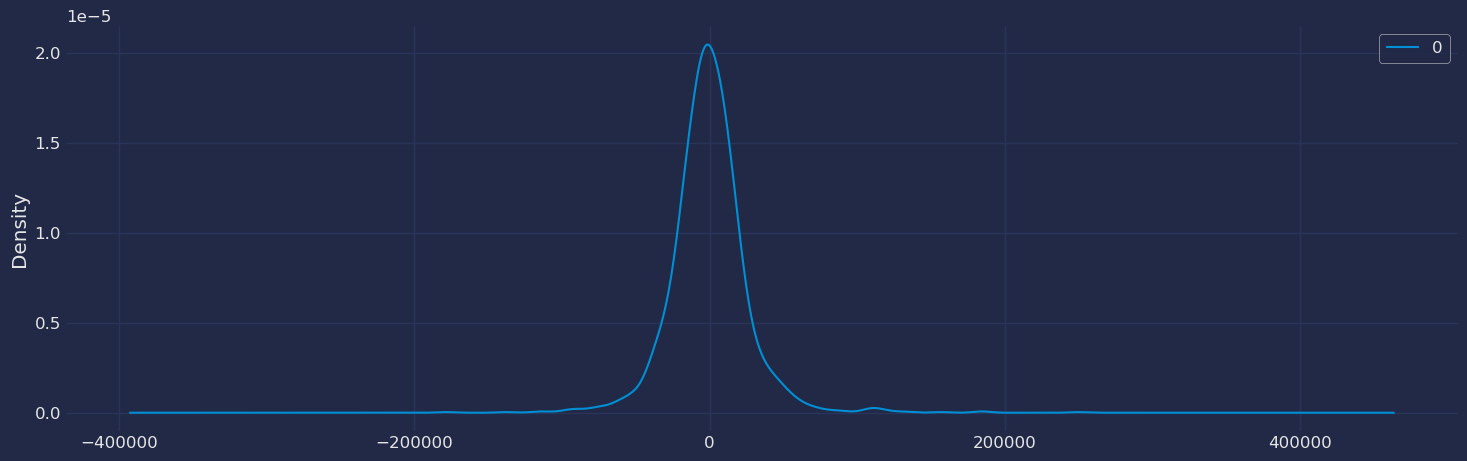

                   0
count    1870.000000
mean     -255.329218
std     26634.610447
min   -178814.705585
25%    -13731.114815
50%      -914.662076
75%     11856.977283
max    249747.024298


In [65]:
residuals.plot(kind = 'kde', figsize = (16,5))
plt.show()
print(residuals.describe())

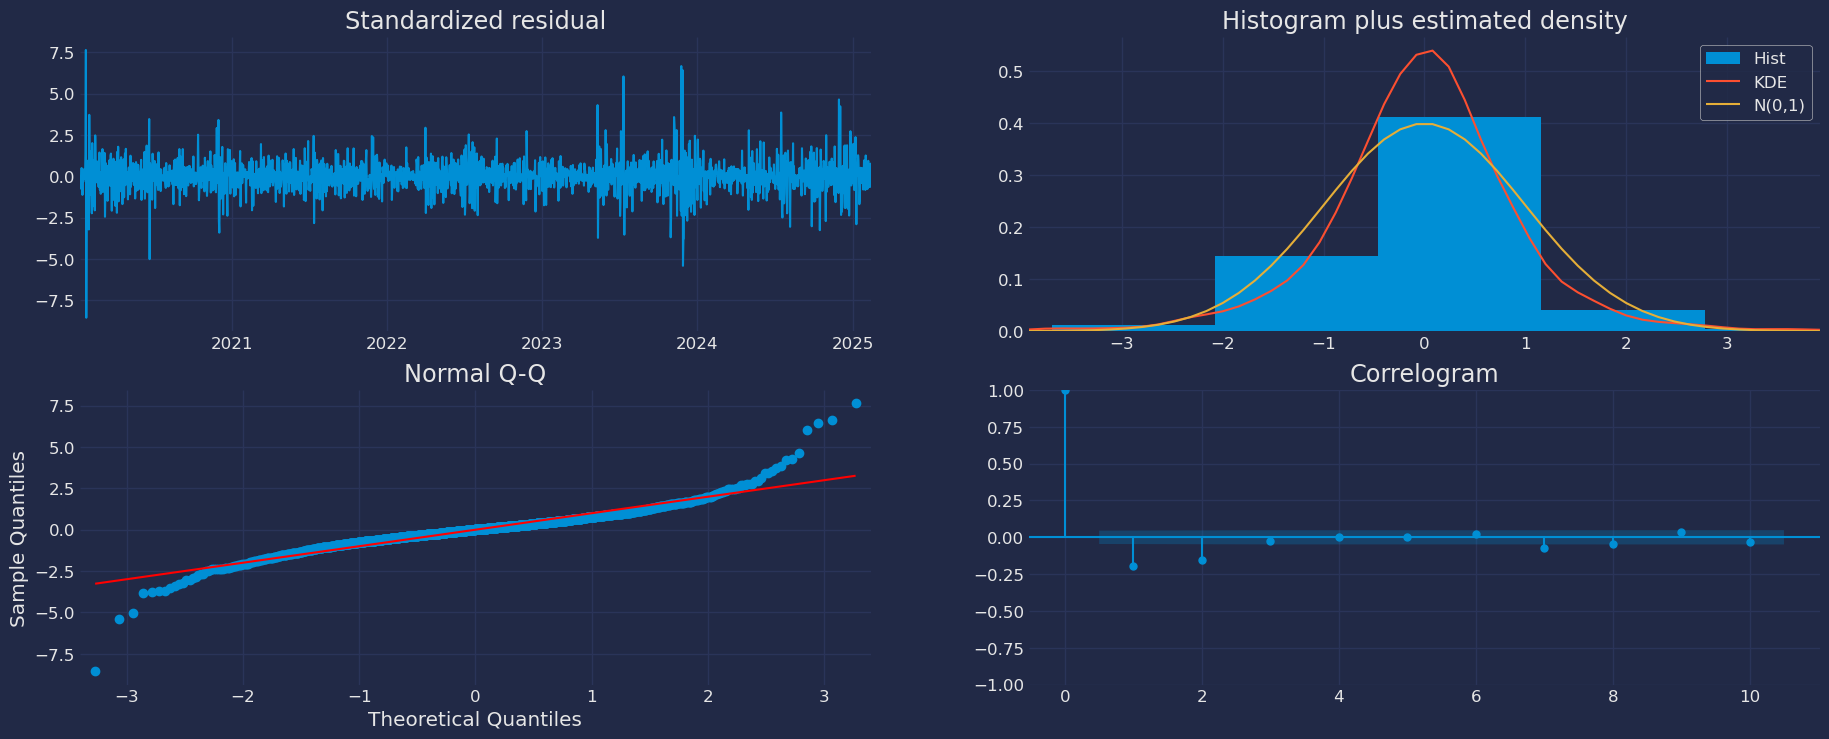

In [66]:
modelo_auto_arima_ventas.plot_diagnostics(figsize=(20,8))
plt.show()

In [67]:
arima_pred_ventas = arima_model_ventas.predict(start=len(train_data), end = len(refunds['Total'])-1, typ = 'levels')
arima_pred_ventas = arima_pred_ventas.abs()
arima_pred_ventas

c:\Users\javij\anaconda3\lib\site-packages\statsmodels\tsa\statespace\representation.py:374: FutureWarning:

Unknown keyword arguments: dict_keys(['typ']).Passing unknown keyword arguments will raise a TypeError beginning in version 0.15.



2025-02-13    231072.872713
2025-02-14    217703.822148
2025-02-15    178089.938482
2025-02-16    188318.529135
2025-02-17    267328.454803
2025-02-18    258808.541814
2025-02-19    246709.124505
2025-02-20    231709.714343
2025-02-21    218642.105740
2025-02-22    179789.756361
2025-02-23    189886.265227
2025-02-24    268850.736659
2025-02-25    259864.229194
2025-02-26    247525.178088
2025-02-27    232551.155149
2025-02-28    219632.320386
2025-03-01    180969.514266
2025-03-02    191055.614621
2025-03-03    270048.555964
2025-03-04    260898.570637
2025-03-05    248493.523942
2025-03-06    233553.029981
2025-03-07    220640.903956
2025-03-08    181989.191838
2025-03-09    192074.073993
2025-03-10    271067.603284
2025-03-11    261909.332919
2025-03-12    249500.595660
2025-03-13    234561.326574
2025-03-14    221650.415108
2025-03-15    183000.330412
2025-03-16    193085.104062
Freq: D, Name: predicted_mean, dtype: float64

In [68]:
arima_pred2_ventas = arima_model_ventas.predict(start = '2025-03-17', end='2025-04-05', typ = 'levels')
arima_pred2_ventas = arima_pred2_ventas.abs()
arima_pred2_ventas

2025-03-17    272078.843910
2025-03-18    262919.210247
2025-03-19    250509.911760
2025-03-20    235570.907377
2025-03-21    222660.079339
2025-03-22    184010.120631
2025-03-23    194094.882653
2025-03-24    273088.633083
2025-03-25    263928.900684
2025-03-26    251519.559662
2025-03-27    236580.571860
2025-03-28    223669.754638
2025-03-29    185019.810869
2025-03-30    195104.571793
2025-03-31    274098.323977
2025-04-01    264938.579277
2025-04-02    252529.233132
2025-04-03    237590.247637
2025-04-04    224679.431318
2025-04-05    186029.488868
Freq: D, Name: predicted_mean, dtype: float64

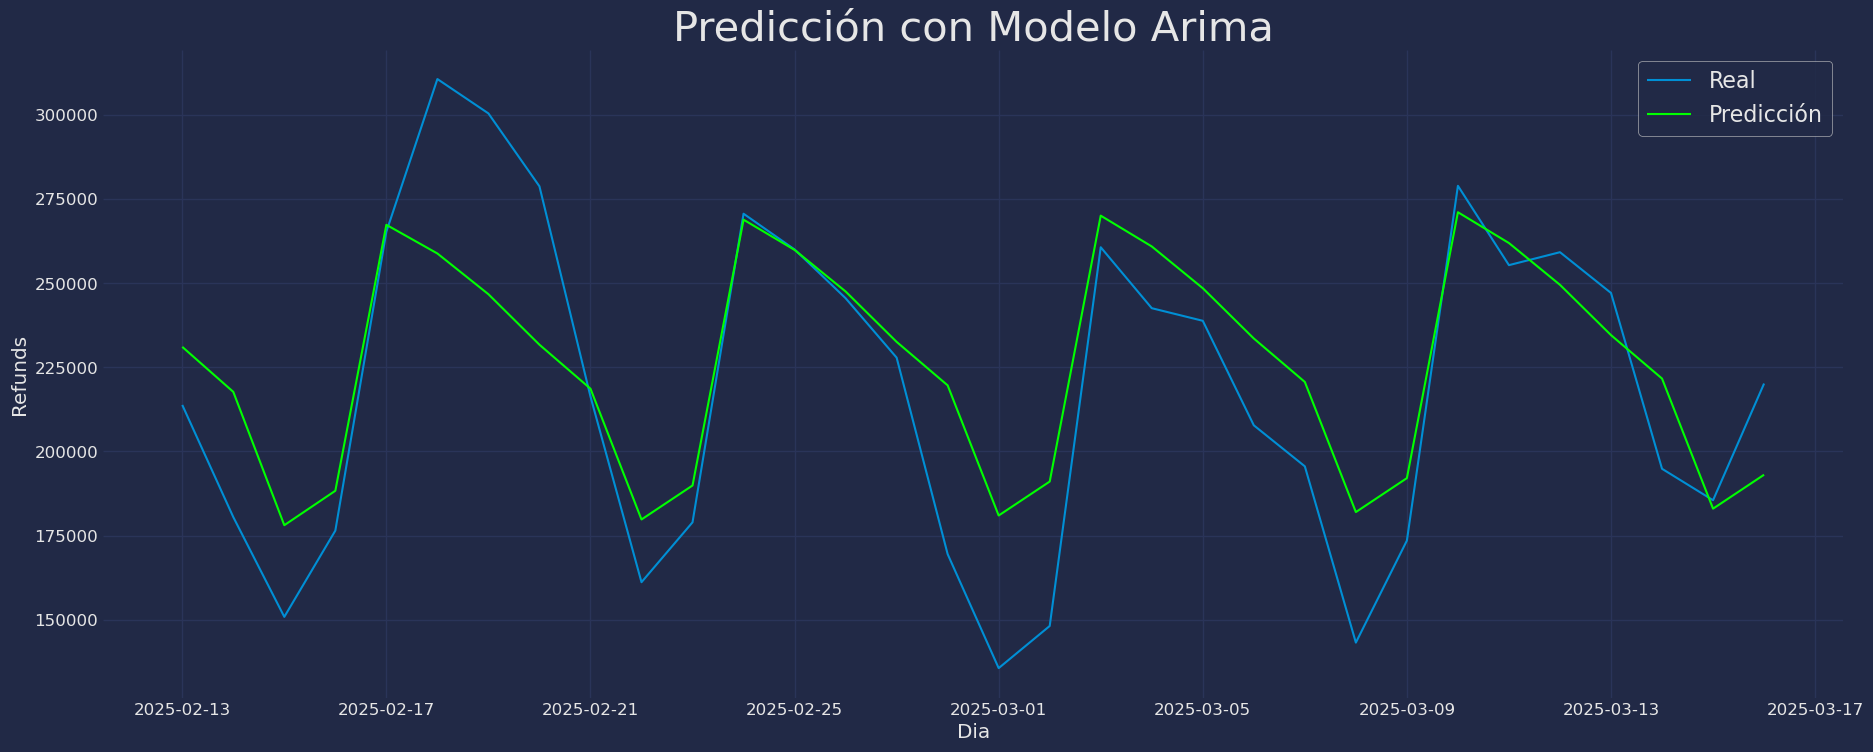

In [69]:
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(test_data2['Total'],label='Real')
plt.plot(arima_pred_ventas,color='lime', label = 'Predicción')
plt.title('Predicción con Modelo Arima', fontsize = 30)
plt.xlabel('Dia')
plt.ylabel('Refunds')
plt.legend(fontsize = 16)
plt.show()

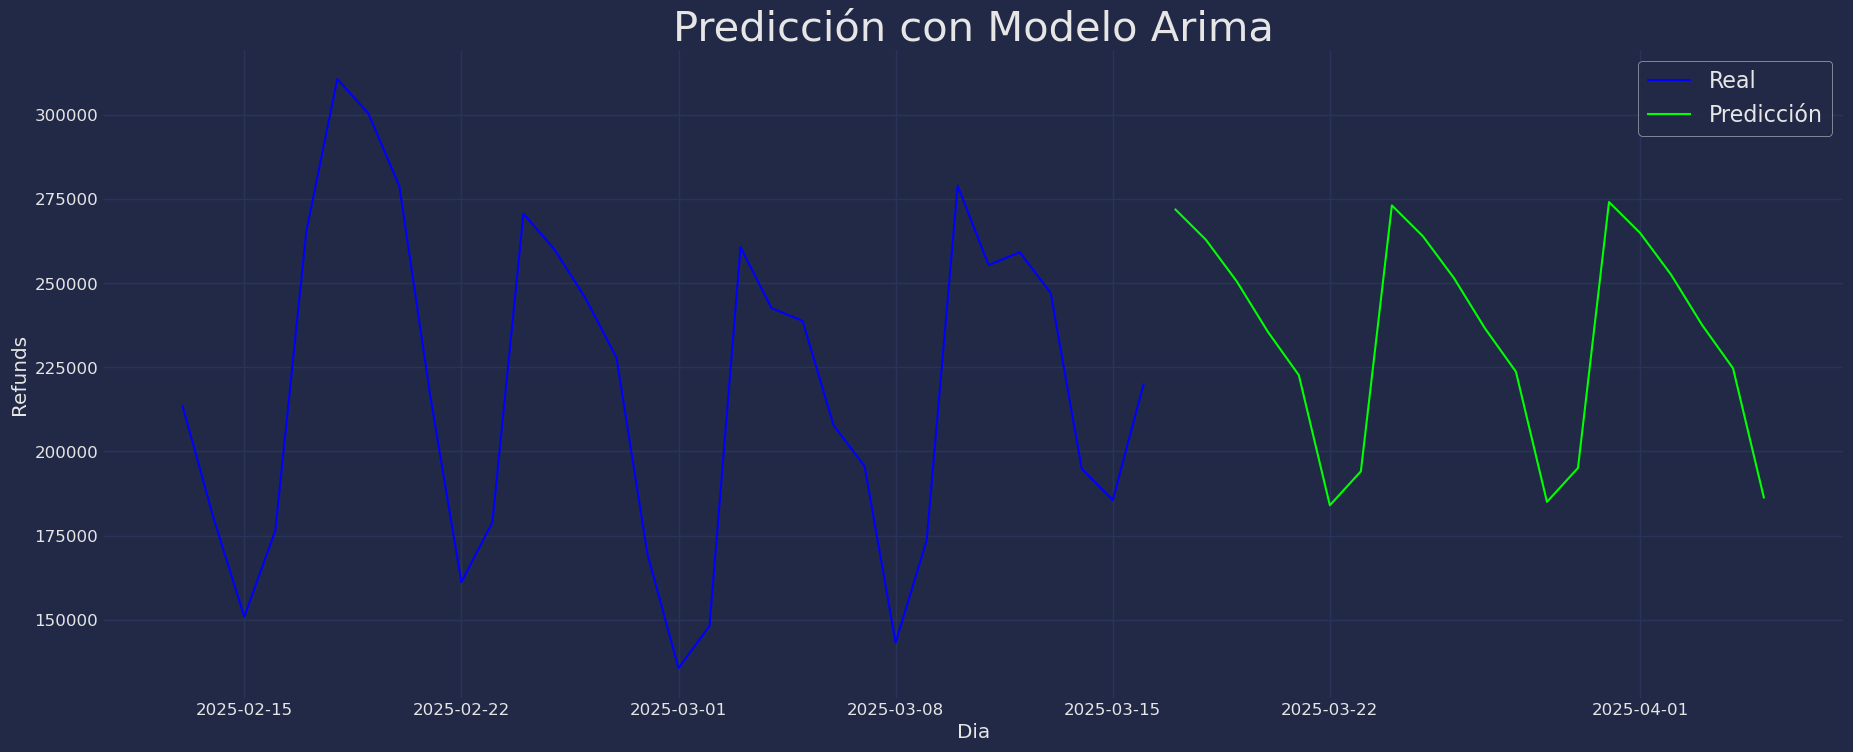

In [70]:
plt.rcParams['figure.figsize'] = (20,8)

plt.plot(test_data2['Total'],label='Real', color ='blue')
plt.plot(arima_pred2_ventas,color='lime', label = 'Predicción')
plt.title('Predicción con Modelo Arima', fontsize = 30)
plt.xlabel('Dia')
plt.ylabel('Refunds')
plt.legend(fontsize = 16)
plt.show()

In [71]:
evaluacion_metricas(test_data2['Total'],arima_pred_ventas)

Evaluación de las metricas resultados:-
MSE es: 710561053.1504657
MAE es: 20801.992107832488
RMSE es: 26656.351084693975
MAPE es: 10.617918204981592
R^2 es: 0.6901914514562183



In [72]:

data = []
for i in range(len(arima_pred2)):
    data.append([arima_pred2[i], arima_pred2_ventas[i]])

# Crea el dataframe a partir de la lista de listas
predicciones_arima = pd.DataFrame(data, columns=['Refunds', 'Sales'])

# Utiliza el índice original en lugar de reindexar con ceros
predicciones_arima.index = pd.date_range(start='2024-11-18', periods=len(arima_pred2), freq='D')

# Imprime las primeras filas del dataframe
print(predicciones_arima.head(15))

# Guarda el dataframe en un archivo Excel
predicciones_arima.to_excel('predicciones arima.xlsx', index=True)



                 Refunds          Sales
2024-11-18  10891.023955  272078.843910
2024-11-19  18936.287108  262919.210247
2024-11-20  11581.265884  250509.911760
2024-11-21  11397.526580  235570.907377
2024-11-22  12185.249014  222660.079339
2024-11-23   6514.926180  184010.120631
2024-11-24   2941.109159  194094.882653
2024-11-25  10911.049202  273088.633083
2024-11-26  18929.154564  263928.900684
2024-11-27  11613.643457  251519.559662
2024-11-28  11413.322870  236580.571860
2024-11-29  12213.020405  223669.754638
2024-11-30   6548.317349  185019.810869
2024-12-01   2973.747991  195104.571793
2024-12-02  10933.233479  274098.323977


In [73]:
import plotly.express as px


historia_refunds = refunds.tail(31)

fig_refunds = px.line(historia_refunds, x=historia_refunds.index, y='Total', template='plotly_dark', title='Historial de Refunds y Predicciones')
fig_refunds.add_trace(go.Scatter(x=predicciones_arima.index, y=predicciones_arima['Refunds'], mode='lines', name='Refunds Predicciones'))

fig_refunds.update_layout(xaxis_title='Fecha', yaxis_title='Refunds', legend_title='Leyenda')

# Mostrar el gráfico
fig_refunds.show()



historia_ventas = ventas.tail(31)

# Crear gráfico para ventas con datos históricos
fig_ventas = px.line(historia_ventas, x=historia_ventas.index, y='Total', template='plotly_dark', title='Historial de Ventas y Predicciones')
fig_ventas.add_trace(go.Scatter(x=predicciones_arima.index, y=predicciones_arima['Sales'], mode='lines', name='Ventas Predicciones'))

# Personalizar diseño
fig_ventas.update_layout(xaxis_title='Fecha', yaxis_title='Ventas', legend_title='Leyenda')

# Mostrar el gráfico
fig_ventas.show()